In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, SimpleRNN


In [2]:
df = pd.read_csv('AzureReadings_at_a_timestamp1.csv')
df['timestamp'] =  pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.head()

,norm_min_cpu,norm_max_cpu,norm_avg
timestamp,,,
2017-01-01 00:00:00,0.2283,0.2346,0.2314
2017-01-01 00:05:00,0.2023,0.2282,0.2152
2017-01-01 00:10:00,0.2120,0.2286,0.2203
2017-01-01 00:15:00,0.1809,0.2137,0.1973
2017-01-01 00:20:00,0.1807,0.2114,0.1960


In [3]:
dataset = df.values
dataset = dataset.astype('float32')

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

6912 1728


In [6]:
def create_training_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :3]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [7]:
look_back = 5
trainX, trainY = create_training_dataset(train, look_back=look_back)
testX, testY = create_training_dataset(test, look_back=look_back)

In [8]:
model2 = keras.models.Sequential()
model2.add(SimpleRNN(units=128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
model2.add(Dense(3))
# model2.add(keras.layers.RNN(cell, input_shape=(trainX.shape[1], trainX.shape[2]),
#                               return_sequences=False))

# model2.add(keras.layers.Dense(3))
# tf.keras.layers.RNN(
#     cell, return_sequences=False, return_state=False, go_backwards=False,
#     stateful=False, unroll=False, time_major=False, **kwargs
# )

In [9]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               16896     
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 17,283
Trainable params: 17,283
Non-trainable params: 0
_________________________________________________________________


In [10]:
adamOpt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=[keras.metrics.mae])

In [11]:
callback = keras.callbacks.EarlyStopping(patience=3)
history2 = model2.fit(trainX, trainY, epochs=20, validation_split=0.25, batch_size=16, verbose=2, shuffle=False)

Epoch 1/20
324/324 - 1s - loss: 0.0023 - mean_absolute_error: 0.0325 - val_loss: 9.8624e-04 - val_mean_absolute_error: 0.0249
Epoch 2/20
324/324 - 1s - loss: 7.2085e-04 - mean_absolute_error: 0.0186 - val_loss: 4.5781e-04 - val_mean_absolute_error: 0.0168
Epoch 3/20
324/324 - 1s - loss: 6.0614e-04 - mean_absolute_error: 0.0172 - val_loss: 4.2622e-04 - val_mean_absolute_error: 0.0160
Epoch 4/20
324/324 - 1s - loss: 5.8201e-04 - mean_absolute_error: 0.0169 - val_loss: 3.9945e-04 - val_mean_absolute_error: 0.0153
Epoch 5/20
324/324 - 1s - loss: 5.6039e-04 - mean_absolute_error: 0.0167 - val_loss: 4.0383e-04 - val_mean_absolute_error: 0.0153
Epoch 6/20
324/324 - 1s - loss: 5.5853e-04 - mean_absolute_error: 0.0167 - val_loss: 3.9345e-04 - val_mean_absolute_error: 0.0150
Epoch 7/20
324/324 - 1s - loss: 5.4941e-04 - mean_absolute_error: 0.0165 - val_loss: 3.9423e-04 - val_mean_absolute_error: 0.0149
Epoch 8/20
324/324 - 1s - loss: 5.6687e-04 - mean_absolute_error: 0.0169 - val_loss: 3.9812e-0

In [12]:
model2.evaluate(testX, testY)

54/54 [==============================] - 0s 942us/step - loss: 6.7804e-04 - mean_absolute_error: 0.0191


[0.0006780396215617657, 0.019135748967528343]

In [13]:
trainPredict = model2.predict(trainX)
testPredict = model2.predict(testX)

In [14]:
trainY = scaler.inverse_transform(trainY)
trainPredict = scaler.inverse_transform(trainPredict)
testY = scaler.inverse_transform(testY)
testPredict = scaler.inverse_transform(testPredict)

In [15]:
trainScore = math.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %f RMSE' % (testScore))

Train Score: 0.020837 RMSE
Test Score: 0.025208 RMSE


In [16]:
from sklearn.metrics import mean_absolute_error
trainScore = (mean_absolute_error(trainY[:], trainPredict[:]))
print('Train Score: %f MAE' % (trainScore))
testScore = math.sqrt(mean_absolute_error(testY[:], testPredict[:]))
print('Test Score: %f MAE' % (testScore))

Train Score: 0.014569 MAE
Test Score: 0.135301 MAE


In [17]:
trainScore2 = np.mean(np.abs(trainPredict - trainY)/np.abs(trainY))
print('Train Score: %f MAPE' % (trainScore2))
testScore2 = np.mean(np.abs(testPredict - testY)/np.abs(testY))
print('Test Score: %f MAPE' % (testScore2))

Train Score: inf MAPE
Test Score: 0.073581 MAPE


C:\Users\91956\AppData\Local\Temp/ipykernel_14260/1226192089.py:1: RuntimeWarning: divide by zero encountered in true_divide
  trainScore2 = np.mean(np.abs(trainPredict - trainY)/np.abs(trainY))


In [ ]:
from sklearn.metrics import mean_absolute_scaled_error
trainScore = (mean_absolute_scaled_error(trainY[:], trainPredict[:]))
print('Train Score: %f MASE' % (trainScore))
testScore = math.sqrt(mean_absolute_scaled_error(testY[:], testPredict[:]))
print('Test Score: %f MASE' % (testScore))

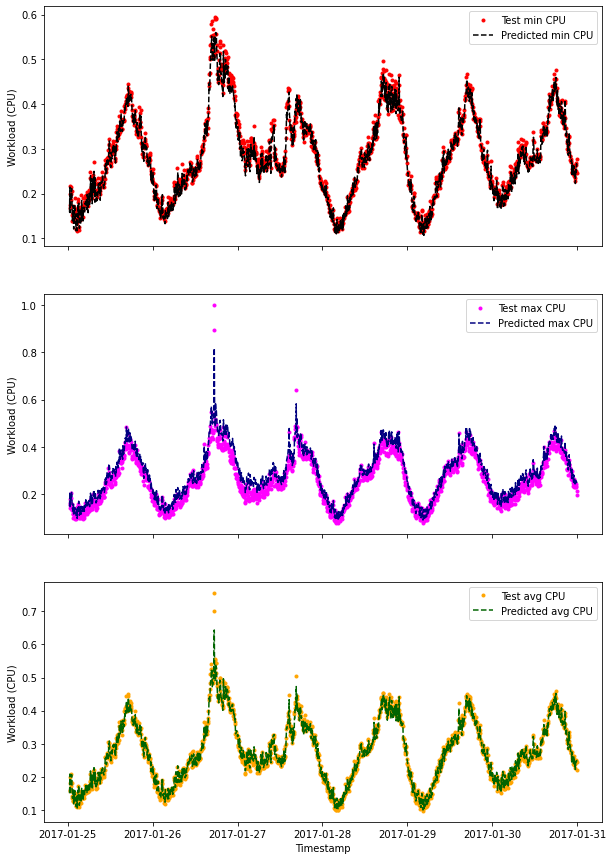

In [19]:

index=df.index
TestY= pd.DataFrame(testY,columns=['min_cpu','max_cpu','avg_cpu'])
PredY=pd.DataFrame(testPredict,columns=['min_cpu','max_cpu','avg_cpu'])

x=index[-1722:]
fig, axs = plt.subplots(3,figsize=(10,15))

axs[0].plot(x,TestY.min_cpu,'.',label='Test min CPU',color='red')
axs[0].plot(x,PredY.min_cpu,'--',label='Predicted min CPU',color='black')
axs[0].legend()
axs[1].plot(x,TestY.max_cpu,'.',label='Test max CPU',color='magenta')
axs[1].plot(x,PredY.max_cpu,'--',label='Predicted max CPU',color='navy')
axs[1].legend()
axs[2].plot(x,TestY.avg_cpu,'.',label='Test avg CPU',color='orange')
axs[2].plot(x,PredY.avg_cpu,'--',label='Predicted avg CPU',color='darkgreen')
axs[2].legend()
for ax in axs.flat:
    ax.set(xlabel='Timestamp', ylabel='Workload (CPU)',autoscale_on=True)
for ax in axs:
    ax.label_outer()
#fig.suptitle('Prediction of Workload on Azure cloud at a particular timestamp',fontsize=20)
plt.savefig('Rnn output.png', dpi = 300)
plt.show()